In [1]:
import os
import sys
# import json
# import requests
# import numpy as np
# import pandas as pd
# from pytz import UTC
# from datetime import timedelta
# from datetime import datetime
# from dateutil.parser import parse

sys.path.append(os.getcwd())
from binance import BINANCE_START_DATE, request_spot_tickers, dump_spot_candles, load_data
from ops import *
from simulator import Simulator

---

Factor alphas

In [39]:
alpha = -data['close']/data['close'].shift()
# alpha = -data['close']/data['close'].shift(5)
# alpha = data['vwap']/data['close']-1
# alpha = -(data['buyFiatVolume']-data['sellFiatVolume'])/(data['buyFiatVolume']+data['sellFiatVolume'])
# alpha = alpha.ewm(4).mean()


alpha = neutralize(alpha)
alpha = normalize(alpha)
for _ in range(5):
    alpha = truncate(alpha,0.1)
    alpha = neutralize(alpha)
    alpha = normalize(alpha)

In [40]:
returns = data['close']/data['close'].shift()-1
vwap_returns = data['vwap']/data['vwap'].shift()-1

In [41]:
# pnl = (alpha.shift()*returns).sum(axis=1)
pnl = ((alpha/data['close']).shift(2)*data['vwap'].diff()).sum(axis=1)
tvr = ((alpha/data['close']).diff().abs().shift()*data['vwap']).sum(axis=1)

<AxesSubplot:xlabel='startTime'>

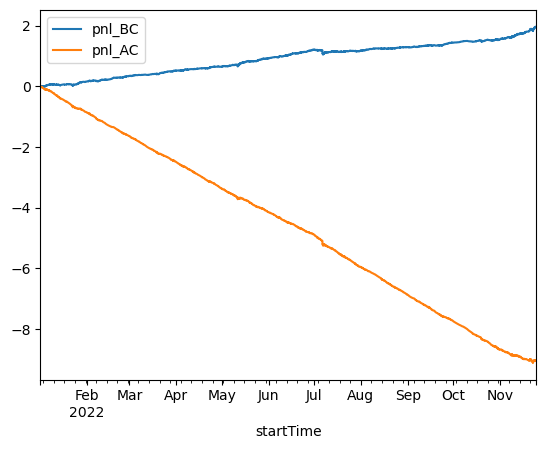

In [42]:
cost_bps = 10e-4
pd.DataFrame({
    'pnl_BC' : pnl,
    'pnl_AC' : pnl-cost_bps*tvr
}).cumsum().plot()

---

<b>Task (2022-11-25)</b>\
For ETH/USDT on 2022-11-01 download all trades \
Build a model that predicts price for the next tick

In [5]:
trades = aggTradesTime('ETH','USDT',int(1000*datetime.datetime.strptime('2022-11-01','%Y-%m-%d').timestamp()),int(1000*datetime.datetime.strptime('2022-11-02','%Y-%m-%d').timestamp()))

In [7]:
trades.to_csv('/home/ezavalnyuk/git/sirius_algo/ethusdt_20221101.csv')
trades['isSell'] = trades['isSell'].astype(bool)

In [76]:
trades

,T,price,volume,isSell,best_bid,best_ask,bid_breakdown,ask_breakdown
793481724,1667250000001,1564.79,0.0280,False,NaN,1564.79,False,False
793481725,1667250000002,1564.79,0.0091,False,NaN,1564.79,False,False
793481726,1667250000008,1564.79,0.0611,False,NaN,1564.79,False,False
793481727,1667250000010,1564.78,0.0273,True,1564.78,1564.79,False,False
793481728,1667250000011,1564.79,0.0070,False,1564.78,1564.79,False,False
...,...,...,...,...,...,...,...,...
793990122,1667336399996,1575.80,0.0627,False,1575.79,1575.80,False,False
793990123,1667336399996,1575.79,0.0256,True,1575.79,1575.80,False,False
793990124,1667336399997,1575.80,0.0232,False,1575.79,1575.80,False,False
793990125,1667336400000,1575.80,0.0099,False,1575.79,1575.80,False,False


In [73]:
trades['best_bid'] = (trades['price']*trades['isSell'].replace(False,np.nan)).ffill()
trades['best_ask'] = (trades['price']*(~trades['isSell']).replace(False,np.nan)).ffill()

In [74]:
# identify those ticks, when isSell == True and bid is less than previous

trades['bid_breakdown'] = trades['isSell'] & (trades['price']<trades['best_bid'].shift())
trades['ask_breakdown'] = (~trades['isSell']) & (trades['price']>trades['best_ask'].shift())

In [94]:
alpha = trades['ask_breakdown'].astype(int)-trades['bid_breakdown'].astype(int)

pnl = (alpha.shift()*trades['price'].diff()).sum()
operations = alpha.abs().sum()
print (pnl,operations,pnl/operations)

3175.849999999986 205060 0.015487418316590198


In [ ]:
# goal -> maximize average pnl by trade
# use volume anomalies

---

<b>Task (2022-11-26)</b> \
Analysis of spot vs future \
Download candles for BTCUSDT from 20220101 until 20220401, interval = 1h
- for spot BTCUSDT ( https://www.binance.com/en/trade/BTC_USDT?_from=markets&theme=dark&type=spot )
- for future contract BTCUSDT ( https://www.binance.com/en/futures/BTCUSDT?_from=markets ) \
Plot ratio future_close/spot_close \

For this purpose implement \
`def request_future_candles(ticker,fiat,interval,startTime,endTime)` \
similar to request_spot_candles above

In [130]:
ticker = 'ETH'
startTime = int(1000*datetime.datetime.strptime('2022-01-01','%Y-%m-%d').timestamp())
endTime = int(1000*datetime.datetime.strptime('2022-11-26','%Y-%m-%d').timestamp())

spot_candles = request_spot_candles(ticker,'USDT','1h',startTime,endTime)
spot_candles.index = spot_candles['startTime'].apply(lambda ts : datetime.datetime.fromtimestamp(ts/1000).strftime('%Y-%m-%d %H:%M:%S'))
spot_candles.drop(['startTime','endTime'],axis=1,inplace=True)

future_candles = request_future_candles(ticker,'USDT','PERPETUAL','1h',startTime,endTime)
future_candles.index = future_candles['startTime'].apply(lambda ts : datetime.datetime.fromtimestamp(ts/1000).strftime('%Y-%m-%d %H:%M:%S'))
future_candles.drop(['startTime','endTime'],axis=1,inplace=True)

In [132]:
future_to_spot_ratio = (future_candles['close']/spot_candles['close'])

<AxesSubplot:xlabel='startTime'>

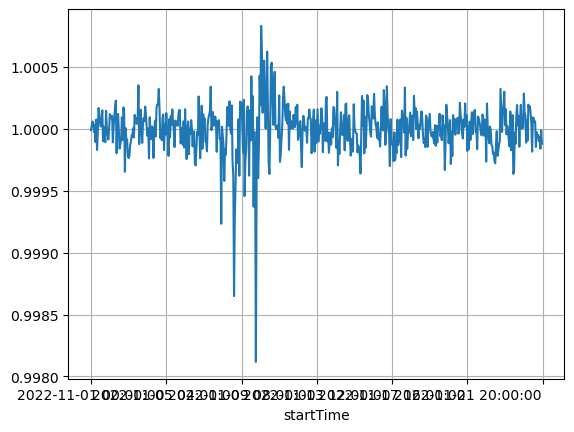

In [141]:
(future_to_spot_ratio / future_to_spot_ratio.rolling(24).mean()).loc['2022-11-01':'2022-11-26'].plot(grid=True)

In [ ]:
future_to_spot_ratio >= future_to_spot_ratio.rolling(24).mean() + future_to_spot_ratio.rolling(24).std() # => short future, long spot
future_to_spot_ratio <= future_to_spot_ratio.rolling(24).mean() - future_to_spot_ratio.rolling(24).std() # => long future, short spot

In [ ]:
# build and simulate signal which buys 1 future and sells 1 spot when future_to_spot_ratio is lower than its average over 24 hours, and vice-versa


<b>Homework (2022-11-26)</b>

Similar to what we did in [14]-[42] \
Dump both spot and future candles for year = 2022 for a set(#=25) of tickers (on your choice)

Design and backtest a signal based on the future to spot ratio

In [16]:
# by Liza B

In [19]:
tickers = ['BTC','ETH','BNB','LTC','XRP','SOL','DOGE','MATIC','LINK','TRX','ETC','ADA','CHZ','BCH','CRV','DOT','AVAX','DYDX','NEAR','ATOM']
fiat = 'USDT'
interval = '1h'
start_date = '2022-01-01'
end_date = '2022-11-25'
contractType = 'PERPETUAL'

spot_data_dir = '/home/ezavalnyuk/git/sirius_algo/data_spot'
future_data_dir = '/home/ezavalnyuk/git/sirius_algo/data_future'

dump_spot_data(tickers,fiat,interval,start_date,end_date,spot_data_dir)
dump_future_data(tickers,fiat,contractType,interval,start_date,end_date,spot_data_dir)

<b>Homework (2022-12-01)</b>

From web page https://www.binance.com/en/markets/futures identify http request which returns list of all available USDT futures

<b>Homework (2022-12-02)</b>

Get all available spot tickers with quoteAsset='USDT' and find first trade date for each symbol

---

---

Working with orderbook

In [169]:
def calc_vwap(levels):
    return np.sum(levels.index*levels.values) / levels.sum()

In [202]:
bids,asks = request_orderbook('ETH','USDT')

In [203]:
bids.sum()

56145.16130000001

In [204]:
asks.sum()

10567.814900000001

<AxesSubplot:xlabel='price'>

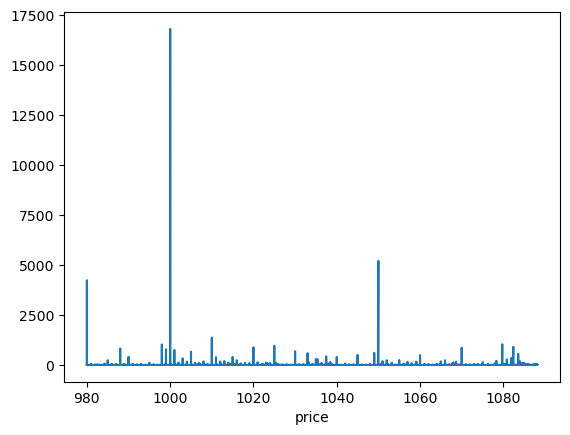

In [205]:
bids.plot()

<AxesSubplot:xlabel='price'>

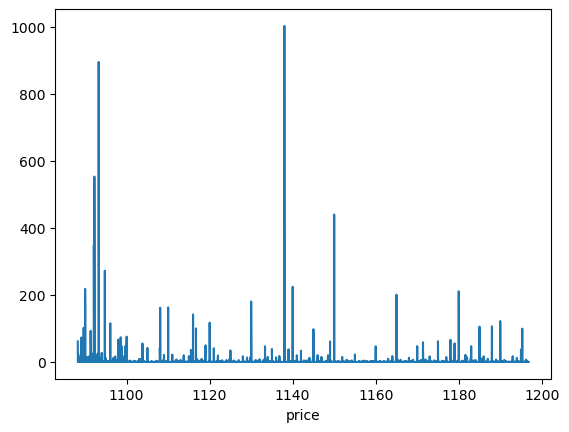

In [206]:
asks.plot()

<AxesSubplot:xlabel='price'>

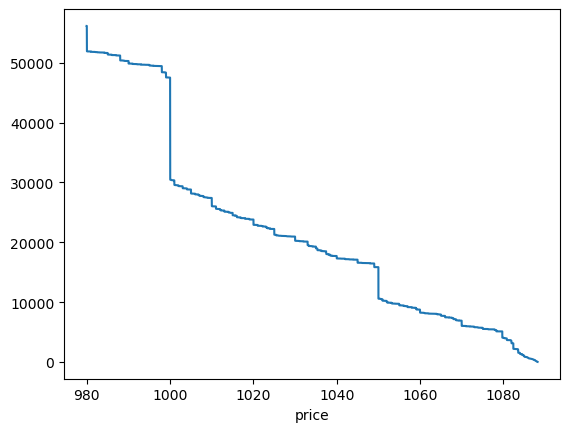

In [207]:
bids.cumsum().plot()

<AxesSubplot:xlabel='price'>

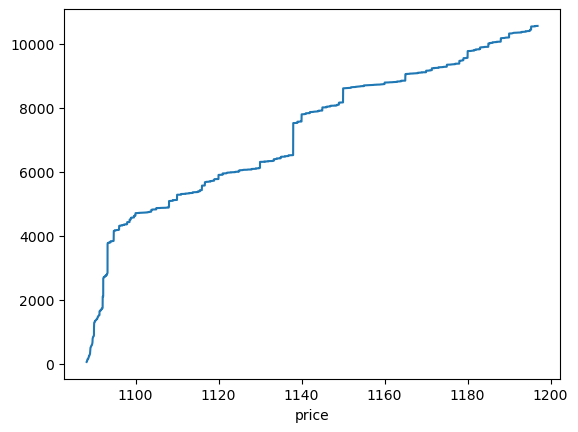

In [208]:
asks.cumsum().plot()

In [209]:
mid_price = (bids.index[0]+asks.index[0])/2
bids_vwap = np.sum(bids.values*bids.index) / bids.sum()
asks_vwap = np.sum(asks.values*asks.index) / asks.sum()

In [210]:
bids_vwap,mid_price,asks_vwap

(1022.0263812961384, 1088.225, 1122.4225358932051)

In [211]:
def split_to_cumulative_buckets(levels,step=50):
    cs = levels.cumsum()
    n = int(np.floor(cs.iloc[-1]/step))
    sls = []
    for i in range(1,n+1):
        j = np.where(cs>=i*step)[0][0]
        sl = levels.iloc[:j+1].copy()
        sl.iloc[-1] = i*step - sl.iloc[:-1].sum()
        sls.append(sl)
    return sls

bid_buckets = split_to_cumulative_buckets(bids,10)
ask_buckets = split_to_cumulative_buckets(asks,10)

In [212]:
mid_price = (bids.index[0]+asks.index[0])/2

In [213]:
calc_vwap(bid_buckets[0]),mid_price,calc_vwap(ask_buckets[0])

(1088.22, 1088.225, 1088.23)

<AxesSubplot:>

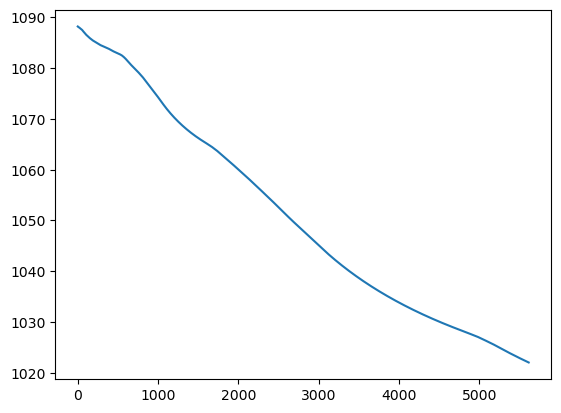

In [214]:
pd.Series([calc_vwap(bid_bucket) for bid_bucket in bid_buckets]).plot()

<AxesSubplot:>

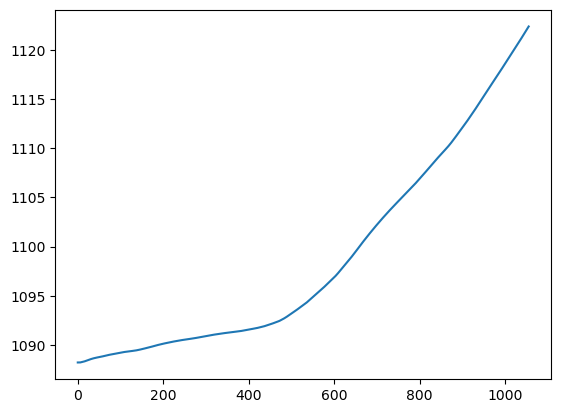

In [215]:
pd.Series([calc_vwap(ask_bucket) for ask_bucket in ask_buckets]).plot()